# CS 230 Project Code

Authors: Delaney Miller and Russell Martin <br>
Class: CS 230: Deep Learning <br>
Date: 16 May 2021 <br>
Description: Predict peak medial knee joint contact force (MCF) from kinematic data (joint angles) during walking using a neural network. This Jupyter Notebook uses open-source code excerpts taken from Boswell et al., 2021 (cited below), who predicted the first peak of knee adduction moment (KAM) from kinematic data in the form of 3D marker coordinates.  This notebook is for testing a variety of neural network architectures as well as combinations of input and output features to evaluate model performance. <br>

Open-source code modified from:

M. A. Boswell et al., “A neural network to predict the knee adduction moment in patients with osteoarthritis using anatomical landmarks obtainable from 2D video analysis,” Osteoarthritis Cartilage, vol. 29, no. 3, pp. 346–356, Mar. 2021, doi: 10.1016/j.joca.2020.12.017.


# Part I: Load and format data

### (1) Load required packages, user inputs

In [4]:
# Taken from from Boswell et al.

# packages 
import scipy.io as sio #
import tensorflow as tf #
import numpy as np #
import scipy.signal
import keras
from keras.models import Sequential
from keras.initializers import glorot_normal
from keras.layers import Dense, Dropout
import tensorflow.python.keras.backend as K
from keras.losses import mean_squared_error
import matplotlib.pyplot as plt #
%matplotlib inline
import csv
import scipy.stats
import os

# Flag if 3D, frontal, or sagittal
modeltype = '3D' # Options are '3D', 'frontal', or 'sagittal'
    
# Configure to use CPU or GPU (we are using CPU)
config = tf.compat.v1.ConfigProto(device_count = {'CPU' : 1, 'GPU' : 0})
session = tf.compat.v1.Session(config=config)
K.set_session(session)

### (2) Define functions for later in script

In [5]:
# Taken from Boswell et al., modified to say "MCF"

def r2_numpy(data,labels,model):
    y_pred2 = model.predict(data)
    mse = np.mean(np.square(y_pred2-labels))
    r2 = np.square(np.corrcoef(labels.T,y_pred2.T)[0,1])
    mae = np.mean(np.abs(y_pred2-labels))
    return r2,mse,mae

def PredictMCF(model,inputData):
    predictedMCF = model.predict(inputData[range(inputData.shape[0]),:])
    return predictedMCF

def PlotMCFpredictions(trueMCF,predictedMCF):
    # Plot predicted and true peaks vs. step
    plt.figure(1)
    truePlot = plt.plot(trueMCF)
    predPlot = plt.plot(predictedMCF)
    plt.ylabel('MCF Peak Comparison')
    plt.xlabel('Step')
    plt.legend(('True','Predicted'),loc=4);

    # Plot predicted vs. true peaks
    plt.figure(2)
    ax = plt.plot(trueMCF,predictedMCF,'.',color=(45/255, 107/255, 179/255),alpha=0.05)
    plt.axis('equal')
    plt.ylabel('Predicted MCF')
    plt.xlabel('True MCF')
    plt.ylim(1,4)
    plt.xlim(1,4)
    plt.plot([-1,4],[-1,4],'k')
    plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    
def PlotTrainingCurves(trainResults,devResults,epochCount):
    # Plot training curves
    lossPlt = plt.plot(np.arange(1,epochCount+1),train_loss[range(epochCount)])
    DevlossPlt = plt.plot(np.arange(1,epochCount+1),dev_loss[range(epochCount)])

    plt.ylabel('Mean Squared Error')
    plt.xlabel('Epoch Number');
    plt.legend(('Training','Dev'))

    plt.figure(2)
    r2Plt = plt.plot(np.arange(1,epochCount+1),train_r2[range(epochCount)])
    devr2Plt = plt.plot(np.arange(1,epochCount+1),dev_r2[range(epochCount)])
    plt.ylim([.2, 1])
    plt.ylabel('r^2')
    plt.xlabel('Epoch Number');
    plt.legend(('Training','Dev'))
    
if modeltype not in ['3D', 'frontal', 'sagittal']:
    raise ValueError("Error: Options are '3D' 'frontal' or 'sagittal'.")

### (3) Load input data

In [6]:
# Load input data
inputData = sio.loadmat("Data\inputData.mat")

# Load input data (X)
ik = inputData["ik"] # time + inverse kinematics (101, 32, 7779)
ik_input = ik[:,1:,:]
time_input = ik[:,0,:]
leg = inputData["leg"].T  # stance leg (per step) (7779,1)
subject = inputData["subject"].T  # subject number (per step) (7779,1)

# Load output data (Y)
MCF = inputData["MCF"] # MCF over time (101, 7779)
peakMCF_early = inputData["peakMCF_early"].T # early stance peak
peakMCF_late = inputData["peakMCF_late"].T # late stance peak
minMCF = inputData["minMCF"].T # mid stance valley

# Print output dimensions
print("Inverse kinematics: " + str(ik_input.shape))
print("Time: " + str(time_input.shape))
print("Stance leg: " + str(leg.shape))
print("Subject number: " + str(subject.shape))
print("Medial contact force: " + str(MCF.shape))
print("Early-stance MCF peak: " + str(peakMCF_early.shape))
print("Late-stance MCF peak: " + str(peakMCF_late.shape))
print("Mid-stance MCF valley: " + str(minMCF.shape))

Inverse kinematics: (101, 31, 7779)
Time: (101, 7779)
Stance leg: (7779, 1)
Subject number: (7779, 1)
Medial contact force: (101, 7779)
Early-stance MCF peak: (7779, 1)
Late-stance MCF peak: (7779, 1)
Mid-stance MCF valley: (7779, 1)


### (4) Format input data

In [51]:
# Leg dimensions (nSamples, 101, 1)
legBin = np.expand_dims(np.tile(leg,(1,101)),axis=2)
print("Leg: " + str(legBin.shape))

# Adjust joint angles to correct dimensions (nSamples, nTimesteps, nFeatures)
angles = np.transpose(ik_input, axes=[2, 0, 1])
print("Joint angles: " + str(angles.shape))

# Time dimensions (nSamples, 1, 1) - DON'T END UP USING
time_input = time_input - time_input[0,:] # make sure each stride starts at 0.0s
time = np.expand_dims(np.transpose(time_input), axis = 2)
print("Time: " + str(time.shape))

# Concatenate legBin with angles
inputMat = np.concatenate((angles, legBin), axis = 2)

# Resample inputMat (nTimesteps = 16, down from 101)
#inputMat = scipy.signal.resample(inputMat, 16, axis = 1)

# Use positions from first half of stance
inputMat = inputMat[:,0:50,:]
print("Input shape: " + str(inputMat.shape))

Leg: (7779, 101, 1)
Joint angles: (7779, 101, 31)
Time: (7779, 101, 1)
Input shape: (7779, 50, 32)


### (5) Format output data (currently just early-stance MCF)

Output shape is (7779, 1, 1)


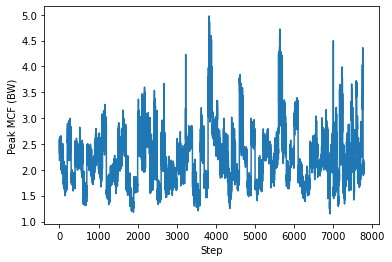

In [52]:
# Reshape the output (nSamples, 1, 1)
output = np.expand_dims(peakMCF_early,axis=2)
print("Output shape is " + str(output.shape))
# next step: multiple outputs (e.g. early and late-stance peaks in MCF)

# Plot output data
plt.plot(output[:,0,0]);
plt.ylabel("Peak MCF (BW)");
plt.xlabel("Step");

### (6) Divide into train, development, and test sets

In [53]:
# Set the seed so it is reproducible
np.random.seed(1)
nSubjects = len(np.unique(subject)) # 68 subjects
subject_shuffle = np.unique(subject)
np.random.shuffle(subject_shuffle)

# 80-10-10 split (54-7-7 subjects)
train, dev, test = np.split(subject_shuffle, [int(0.8*len(subject_shuffle)), int(0.9*len(subject_shuffle))])
print("Train: " + str(len(train)) + " subjects")
print("Dev: " + str(len(dev)) + " subjects")
print("Test: " + str(len(test)) + " subjects")

# Find step indicies for each subject in each set (taken from Boswell et al., 2021)
trainInds = np.array(0)
for i in train:
    trainInds = np.append(trainInds,np.argwhere(subject==i))
trainInds = trainInds[1:]
    
devInds = np.array(0)
for i in dev:
    devInds = np.append(devInds,np.argwhere(subject==i))
devInds = devInds[1:]

testInds = np.array(0)
for i in test:
    testInds = np.append(testInds,np.argwhere(subject==i))
testInds = testInds[1:]

# Build training, development, and test inputs and labels (taken from Boswell et al., 2021)
trainInput_full = inputMat[trainInds,:,:]
trainInput_full = trainInput_full.reshape((trainInput_full.shape[0],-1)) # flatten
trainLabels = output[trainInds,0]

devInput_full = inputMat[devInds,:,:]
devInput_full = devInput_full.reshape((devInput_full.shape[0],-1)) # flatten
devLabels = output[devInds,0]

testInput_full = inputMat[testInds,:,:]
testInput_full = testInput_full.reshape((testInput_full.shape[0],-1))
testLabels = output[testInds,0]

Train: 54 subjects
Dev: 7 subjects
Test: 7 subjects


### (7) Remove redundant leg inputs

In [54]:
# Extract indices of leg (every 32nd index, leave first one)
inputIdx = np.delete(np.arange(0,trainInput_full.shape[1]), np.arange(63, trainInput_full.shape[1], 32))

# Could also do some sort of input feature selection here if we wanted to!

# Remove additional leg input features
trainInput = trainInput_full[:,inputIdx]
devInput = devInput_full[:,inputIdx]
testInput = testInput_full[:,inputIdx]

print("Train input: " + str(trainInput.shape))
print("Dev input: " + str(devInput.shape))
print("Test input: " + str(testInput.shape))


Train input: (12318, 1551)
Dev input: (1640, 1551)
Test input: (1600, 1551)


# Part II: Train neural network

### (8) Construct model function

In [55]:
# Code taken from Boswell et al.
# We added L2 regularizers

train_r2 = np.empty((1000,1))
dev_r2 = np.empty((1000,1))
train_loss = np.empty((1000,1))
dev_loss = np.empty((1000,1))
epochCount = 0 ;

def construct_model(nHiddenUnits, nHiddenLayers, input_dim, output_dim):
    np.random.seed(1)
    tf.compat.v1.set_random_seed(1)

    model = Sequential()
    model.add(Dense(800,input_shape = (input_dim,), kernel_initializer=glorot_normal(seed=None) , activation='relu'))
    kernel_regularizer= tf.keras.regularizers.l2(0.01) # added
    bias_regularizer= tf.keras.regularizers.l2(0.01) # added
    for i in range(nHiddenLayers-1):
        model.add(Dropout(0.01))
        model.add(Dense(nHiddenUnits, kernel_initializer=glorot_normal(seed=None) , activation='relu'))
        kernel_regularizer = tf.keras.regularizers.l2(0.01) # added
        bias_regularizer = tf.keras.regularizers.l2(0.01) # added
    
    model.add(Dropout(0.01))
    model.add(Dense(1,kernel_initializer=glorot_normal(seed=None),activation='linear'))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

model = construct_model(nHiddenUnits = 100, nHiddenLayers = 1, input_dim = trainInput.shape[1], output_dim = trainLabels.shape[1])
model.summary()


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 800)               1241600   
_________________________________________________________________
dropout_60 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 801       
Total params: 1,242,401
Trainable params: 1,242,401
Non-trainable params: 0
_________________________________________________________________


### (9) Train a model with customized inputs

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 800)               1241600   
_________________________________________________________________
dropout_61 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 100)               80100     
_________________________________________________________________
dropout_62 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_63 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 100)             

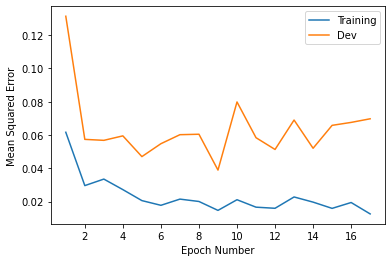

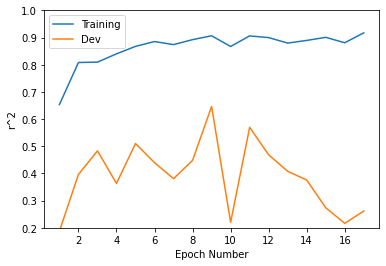

In [56]:
# Code taken from Boswell et al., 2021
# We modified hyperparameters such as nHiddenUnits, nHiddenLayers

nEpochs = 30
models = [] ;

train_r2 = np.zeros((1000,1))
dev_r2 = np.zeros((1000,1))
train_loss = np.zeros((1000,1))
dev_loss = np.zeros((1000,1))
train_mae = np.zeros((1000,1))
dev_mae = np.zeros((1000,1))
epochCount = 0 ;

thisModel = construct_model(nHiddenUnits = 100, nHiddenLayers = 5, input_dim = trainInput.shape[1], output_dim = trainLabels.shape[1])
thisModel.summary()

for i in range(nEpochs):
    print('Epoch ' + str(i+1) + ' of ' + str(nEpochs) + '.')

    history = thisModel.fit(trainInput,trainLabels, epochs=1 , batch_size = 32, shuffle = True, verbose=2)

    train_r2[epochCount], train_loss[epochCount], train_mae[epochCount] = r2_numpy(trainInput,trainLabels,thisModel)
    dev_r2[epochCount], dev_loss[epochCount], dev_mae[epochCount] = r2_numpy(devInput,devLabels,thisModel)
    print('Train_loss = ' + str(train_loss[epochCount]) + ', Train_r2 = ' + str(train_r2[epochCount]) + ', Dev_loss = ' + str(dev_loss[epochCount]) + ', Dev_r2 = ' + str(dev_r2[epochCount]))

    devBest = np.argmin(dev_loss[dev_loss !=0])
    if i-devBest > 8: # stop training if dev hasn't gotten better in last 6 epochs
        print('No Longer Improving')
        break
        
    if i == devBest:
        model = keras.models.clone_model(thisModel)
        model.set_weights(thisModel.get_weights())
        print('saving best model')

    epochCount = epochCount + 1 ;
            
bestEpoch = np.argmin(dev_loss[dev_loss !=0])
print('For Best Epoch:' + str(bestEpoch+1) + ' Train r2 =' + str(train_r2[bestEpoch]) + ' Dev r2 =' + str(dev_r2[bestEpoch]))

# Plot training curves
PlotTrainingCurves(train_r2,dev_r2,epochCount)

### (10) Save newly trained model

In [57]:
# Taken from Boswell et al., 2021

# Make directory for newly trained models
if not os.path.isdir('NewlyTrainedModels'):
    os.mkdir('NewlyTrainedModels')

# Serialize model to JSON
model_json = model.to_json()
with open("NewlyTrainedModels/NeuralNet_" + modeltype + "_newModel.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("NewlyTrainedModels/NeuralNet_" + modeltype + "_newModel_weights.h5")
print("Saved model to disk")

Saved model to disk


### (11) Evaluate Predictions

r2 = 0.6413423663357725, MSE = 0.03293646399010877, MAE = 0.10127209094023132


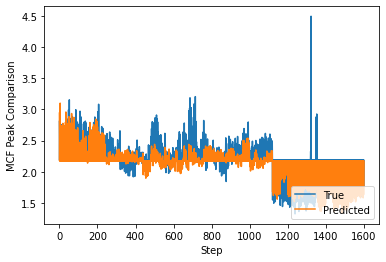

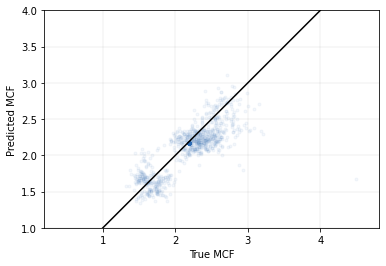

In [59]:
# Taken from Boswell et al., 2021

# Evaluate model performance on one of the data splits
# Change BOTH INPUT AND LABELS for data split that you'd like to use for model evaluation
inputForEval = testInput # options: trainInput, devInput, testInput
labelsForEval = testLabels # options: trainLabels, devLabels, testLabels

# Only after model hyperparameter tuning was finished, we evaluated on test set
predictionsForEval = PredictMCF(model,inputForEval)

# Plot predicted vs true KAM predictions
PlotMCFpredictions(labelsForEval,predictionsForEval)

# Print performance metrics
evaluatedMetrics = r2_numpy(inputForEval,labelsForEval,model)
print('r2 = ' + str(evaluatedMetrics[0]) + ', MSE = ' + str(evaluatedMetrics[1])+ ', MAE = ' + str(evaluatedMetrics[2]))